<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Fit_HCP_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# --- Setup cell ---

# 1️⃣ Mount Google Drive (for data)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2️⃣ Clone GitHub repository (for code)
!git clone https://github.com/grabuffo/BrainStim_ANN_fMRI_HCP.git

# 3️⃣ Define paths
import os, sys

repo_dir = "/content/BrainStim_ANN_fMRI_HCP"
data_dir = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"
preproc_dir = os.path.join(data_dir, "preprocessed_subjects")

sys.path.append(repo_dir)

# 4️⃣ Import packages
import numpy as np
import matplotlib.pyplot as plt
import torch
from src import NPI
import gc

# 5️⃣ Check device
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Running on:", torch.cuda.get_device_name(0))
else:
    print("⚠️  GPU not detected — training will run on CPU.")

Mounted at /content/drive
Cloning into 'BrainStim_ANN_fMRI_HCP'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 110 (delta 32), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (110/110), 22.08 MiB | 7.85 MiB/s, done.
Resolving deltas: 100% (32/32), done.
PyTorch version: 2.8.0+cu126
CUDA available: True
Running on: Tesla T4


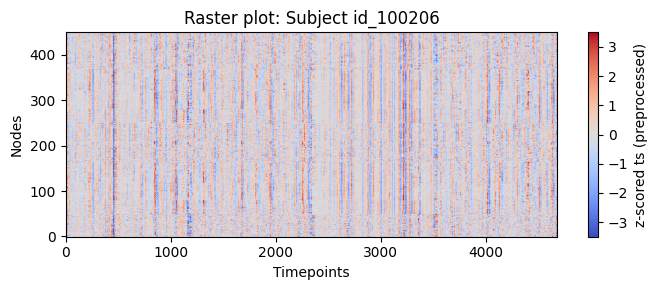

In [9]:
# --- Visualize one subject's preprocessed fMRI data ---

# Pick one subject to visualize (first available)
subject_files = sorted([f for f in os.listdir(preproc_dir) if f.endswith("_signals.npy")])
subject_ids = [f.split("_signals.npy")[0] for f in subject_files]
subj_id = subject_ids[0]  # first subject

# Load its preprocessed signals
subj_signals = np.load(os.path.join(preproc_dir, f"{subj_id}_signals.npy"))

# z-score across time for visualization (optional)
subj_z = (subj_signals - subj_signals.mean(axis=0)) / subj_signals.std(axis=0)

# Raster plot
plt.figure(figsize=(7, 3))
plt.imshow(subj_z.T, aspect='auto', origin='lower', vmin=-3.5, vmax=3.5, cmap='coolwarm')
plt.colorbar(label='z-scored ts (preprocessed)')
plt.xlabel('Timepoints')
plt.ylabel('Nodes')
plt.title(f'Raster plot: Subject {subj_id}')
plt.tight_layout()
plt.show()


In [23]:
# --- Training parameters ---

# Choose ANN architecture: 'MLP', 'CNN', 'RNN', or 'VAR'
method = "MLP"

# Model and training hyperparameters
ROI_num = 450
using_steps = 3
batch_size = 64
train_set_proportion = 0.9
num_epochs = 50
learning_rate = 5e-4
l2_reg = 5e-5

print(f"Training configuration:")
print(f"  Method: {method}")
print(f"  Regions: {ROI_num}")
print(f"  Steps: {using_steps}")
print(f"  Epochs: {num_epochs}")
print(f"  Batch size: {batch_size}")

Training configuration:
  Method: MLP
  Regions: 450
  Steps: 3
  Epochs: 50
  Batch size: 64


### Understanding `signals`, `inputs`, and `targets`

Let **T** = total number of time points and **S** = number of past steps.

---

**`signals`**  
- Shape: **(T, N)**  
- Preprocessed fMRI time series (after removing first 30 TRs, filtering, and concatenating runs).  
- `signals[t, n]` = BOLD activity of region *n* at time *t*.

---

**`inputs`**  
- Shape: **(T − S, N × S)**  
- Each row contains the flattened activity of all N regions over the past S time points.  
- Represents the temporal context used for prediction.

---

**`targets`**  
- Shape: **(T − S, N)**  
- Each row is the brain activity at the next time point following the input window.  
- What the model aims to predict.


In [24]:
# --- Train a model for each subject ---

subject_files = sorted([f for f in os.listdir(preproc_dir) if f.endswith("_signals.npy")])
subject_ids = [f.split("_signals.npy")[0] for f in subject_files]

print(f"\nFound {len(subject_ids)} subjects to train on.\n")

results = {}

for sid in subject_ids:
    print(f"🚀 Training model for subject {sid} ({method})")

    # Load data
    inputs = np.load(os.path.join(preproc_dir, f"{sid}_inputs.npy"))
    targets = np.load(os.path.join(preproc_dir, f"{sid}_targets.npy"))

    # Initialize model
    model = NPI.build_model(method, ROI_num, using_steps)

    # Train model
    model, train_loss, test_loss = NPI.train_NN(
        model,
        inputs,
        targets,
        batch_size=batch_size,
        train_set_proportion=train_set_proportion,
        num_epochs=num_epochs,
        lr=learning_rate,
        l2=l2_reg,
    )

    # Save per-subject results
    results[sid] = {"train_loss": train_loss, "test_loss": test_loss}
    print(f"✅ Done {sid} | Final test loss: {test_loss[-1]:.6f}\n")

    # Free memory between subjects
    del inputs, targets, model
    gc.collect()
    torch.cuda.empty_cache()

# Save summary of all results
results_path = os.path.join(preproc_dir, f"ANN_results_{method}.npy")
np.save(results_path, results, allow_pickle=True)

print("🎯 All subjects trained successfully!")
print(f"📁 Results saved to: {results_path}")


Found 10 subjects to train on.

🚀 Training model for subject id_100206 (MLP)
✅ Done id_100206 | Final test loss: 0.240307

🚀 Training model for subject id_100307 (MLP)
✅ Done id_100307 | Final test loss: 0.280403

🚀 Training model for subject id_100408 (MLP)
✅ Done id_100408 | Final test loss: 0.142906

🚀 Training model for subject id_101006 (MLP)
✅ Done id_101006 | Final test loss: 0.231768

🚀 Training model for subject id_101107 (MLP)
✅ Done id_101107 | Final test loss: 0.125662

🚀 Training model for subject id_101309 (MLP)
✅ Done id_101309 | Final test loss: 0.272142

🚀 Training model for subject id_101915 (MLP)
✅ Done id_101915 | Final test loss: 0.168414

🚀 Training model for subject id_102008 (MLP)
✅ Done id_102008 | Final test loss: 0.150376

🚀 Training model for subject id_102109 (MLP)
✅ Done id_102109 | Final test loss: 0.143400

🚀 Training model for subject id_102311 (MLP)
✅ Done id_102311 | Final test loss: 0.159468

🎯 All subjects trained successfully!
📁 Results saved to: 

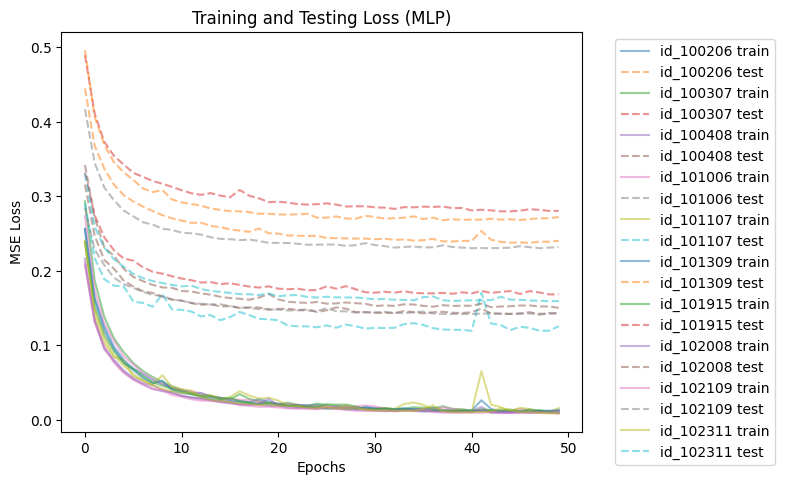

In [25]:
# --- Visualize learning curves ---

results = np.load(results_path, allow_pickle=True).item()

plt.figure(figsize=(8,5))
for sid, vals in results.items():
    plt.plot(vals["train_loss"], label=f"{sid} train", alpha=0.5)
    plt.plot(vals["test_loss"], label=f"{sid} test", linestyle="--", alpha=0.5)

plt.title(f"Training and Testing Loss ({method})")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [26]:
# --- Save model weights for each subject ---

save_models = True

if save_models:
    weights_dir = os.path.join(preproc_dir, f"trained_models_{method}")
    os.makedirs(weights_dir, exist_ok=True)

    for sid in subject_ids:
        model = NPI.build_model(method, ROI_num, using_steps)
        model_path = os.path.join(weights_dir, f"{sid}_{method}.pt")
        torch.save(model.state_dict(), model_path)

    print(f" Saved trained model weights in: {weights_dir}")


 Saved trained model weights in: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects/trained_models_MLP
